In [1]:
"""
Load Gaussian processes inverse models and evaluate accuracy. 

Note: full models require approx 200 Gb of RAM for each model. 

Created by N Naughton on August 4, 2019
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import chaospy as cp
from SALib.sample import saltelli
from SALib.analyze import sobol
        
problem = {
            'num_vars': 7,
    
            'names': ['diameter', 
                      'packing', 
                      'perm', 
                      'Din', 
                      'Dex', 
                      'b-value',
                      'diff_time'],
    
            'bounds': [[10e-6, 80e-6 ], # diameter
                      [0.70  , 0.95  ], # volume fraction
                      [10e-6 , 100e-6], # permeability
                      [0.5e-9, 2.5e-9], # Din
                      [0.5e-9, 2.5e-9], # Dex
                      [300e6, 1200e6],  # b-value
                      [0.0100, 0.750]], # Diffusion Time

            'names_clean': ['Diameter', 
                            'Volume\nFraction', 
                            'Permeability', 
                            'Intracellular\nDiffusion', 
                            'Extracellular\nDiffusion', 
                            'B-Value',
                            'Diffusion\nTime']
            }

In [2]:
meta_model = {}
order = '7_order'
meta_model[order]= {}
[meta_model[order]['FA'], meta_model[order]['MD'], meta_model[order]['RD'], 
 meta_model[order]['L1'], meta_model[order]['L2'], meta_model[order]['L3']] =  pickle.load( open('../pickled_metamodels_7_new_new.pkl', 'rb'), encoding='latin1')[0]

 
mm_full = {your_key: meta_model[order][your_key] for your_key in ['FA','RD','L1']}
mm_full.keys()

dict_keys(['FA', 'RD', 'L1'])

In [3]:
b_range = np.array([400e6, 600e6, 800e6, 1000e6, 1200e6])*1e-7
diff_range = np.array([0.02, 0.05, 0.1, 0.2, 0.4, 0.7])*1e2

# Create dictonary for each pulse profile that will be used in inversion
mm = {}
for b in b_range:
    mm[b] = {}
    for delta in diff_range:
        mm[b][delta] = {}
        for key in mm_full.keys():
            mm[b][delta][key] = mm_full[key](np.ma.masked,np.ma.masked,np.ma.masked,np.ma.masked,np.ma.masked,b,delta)

In [4]:
from sample import sample
problem_train = {'num_vars': 5,   
            'bounds': [[10e-6, 80e-6 ], # diameter
                      [0.70  , 0.95  ], # volume fraction
                      [10e-6 , 100e-6], # permeability
                      [0.5e-9, 2.5e-9], # Din
                      [0.5e-9, 2.5e-9]] # Dex
                       }

training_points = 750
param_values = sample(problem_train, training_points)

# ############################################
inputs_unscaled = param_values
input_scaled = inputs_unscaled*[1e6,1e2,1e6,1e10,1e10]
inputs = input_scaled.T
inputs.shape

(5, 9000)

In [5]:
mm_evals = {}
for b in b_range:
    mm_evals[b] = {}
    print('starting',b*10)
    for delta in diff_range:
        mm_evals[b][delta] = {}
        for key in mm_full.keys():
            mm_evals[b][delta][key] = mm[b][delta][key](inputs[0],inputs[1],inputs[2],inputs[3],inputs[4])

            mm_evals[b][delta]['FA']
df_mm_train = pd.DataFrame(data = inputs.T, columns = problem['names'][:5])
for b in b_range:
    for delta in diff_range:
        for key in mm_full.keys():
            df_mm_train['%s_%s_%s' % (int(b*10), int(delta*10),key)] = mm_evals[b][delta][key]


starting 400.0
starting 600.0
starting 800.0
starting 1000.0
starting 1200.0


In [6]:
rang = problem['bounds']

param_values = []

mean = np.mean(rang,1) - (np.mean(rang,1) - np.min(rang,1))/2
temp = mean[:5]
for i in range(5):
    temp_array = np.array([temp]*200)
    temp_array[:,i] = np.linspace(rang[i][0],rang[i][1],200)
    param_values.append(temp_array)

mean = np.mean(rang,1) 
temp = mean[:5]    
for i in range(5):
    temp_array = np.array([temp]*200)
    temp_array[:,i] = np.linspace(rang[i][0],rang[i][1],200)
    param_values.append(temp_array)

mean = np.max(rang,1) - (np.mean(rang,1) - np.min(rang,1))/2
temp = mean[:5]
for i in range(5):
    temp_array = np.array([temp]*200)
    temp_array[:,i] = np.linspace(rang[i][0],rang[i][1],200)
    param_values.append(temp_array)
param_values = np.vstack(param_values)

inputs_unscaled = param_values
input_scaled = inputs_unscaled*[1e6,1e2,1e6,1e10,1e10]
inputs = input_scaled.T


test_evals = {}
# print('Generating testing data from the meta-model. \nCreating ',rand.shape[1], 'pts' )
for b in b_range:
    test_evals[b] = {}
    print('starting b =',b*10)
    for delta in diff_range:
        test_evals[b][delta] = {}
        for key in mm_full.keys():
            test_evals[b][delta][key] = mm[b][delta][key](inputs[0],inputs[1],inputs[2],inputs[3],inputs[4])

test_evals[b][delta]['FA']
df_test = pd.DataFrame(data = inputs.T, columns = problem['names'][:5])
for b in b_range:
    for delta in diff_range:
        for key in mm_full.keys():
            df_test['%s_%s_%s' % (int(b*10), int(delta*10),key)] = test_evals[b][delta][key]
         

starting b = 400.0
starting b = 600.0
starting b = 800.0
starting b = 1000.0
starting b = 1200.0


In [7]:
rang = problem['bounds']
rand = np.random.rand(7,2000)
param_values = []
for i in range(5):
    r_min = rang[i][0]
    r_max = rang[i][1]
    param_values.append( rand[i] * (r_max - r_min) + r_min )
param_values = np.vstack(param_values).T

inputs_unscaled = param_values
input_scaled = inputs_unscaled*[1e6,1e2,1e6,1e10,1e10]
inputs = input_scaled.T


test_evals = {}
print('Generating testing data from the meta-model. \nCreating ',rand.shape[1], 'pts' )
for b in b_range:
    test_evals[b] = {}
    print('starting b =',b*10)
    for delta in diff_range:
        test_evals[b][delta] = {}
        for key in mm_full.keys():
            test_evals[b][delta][key] = mm[b][delta][key](inputs[0],inputs[1],inputs[2],inputs[3],inputs[4])

test_evals[b][delta]['FA']
df_test2 = pd.DataFrame(data = inputs.T, columns = problem['names'][:5])
for b in b_range:
    for delta in diff_range:
        for key in mm_full.keys():
            df_test2['%s_%s_%s' % (int(b*10), int(delta*10),key)] = test_evals[b][delta][key]
         

Generating testing data from the meta-model. 
Creating  2000 pts
starting b = 400.0
starting b = 600.0
starting b = 800.0
starting b = 1000.0
starting b = 1200.0


In [8]:

import numpy as np
import pandas as pd
from add_SNR import *
import importlib
import add_SNR
importlib.reload(add_SNR)

# set file locations
res = './_results_all_testing.csv'
pulse = './_pulse_info_all_testing.csv'

# set Rician noise level. Typical values are SNR from 20 - 100.  
# For no noise, set SNR = np.inf
SNR = np.inf
# SNR = 50

(dMRI, inputs, vectors) = readin_add_SNR(res, pulse, SNR, sym = True)

all_info_testing = pd.concat([inputs,dMRI],axis = 1)
all_info_testing.insert(0, 'index_num', all_info_testing['case_num'].values)
all_info_full_testing = all_info_testing.sort_values('sim_num')
vectors_full = vectors
print('there are ', len(all_info_testing), 'simulations')
print(' ')

all_info_testing['ms_id'] = all_info_testing['sim_num'] // 30
all_info_testing['pulse_id'] = all_info_testing['sim_num'] % 30

dti_res = all_info_testing[['ms_id','pulse_id','FA', 'MD', 'RD', 'L1', 'L2', 'L3']]

 # combine all dti data into row columns for each unique microstrucutre setup
df = dti_res.groupby('ms_id')[['FA', 'MD', 'RD', 'L1', 'L2', 'L3']].apply(
    lambda x: pd.DataFrame(x.values)).unstack().reset_index()
df.columns = df.columns.droplevel()

ms_pts = all_info_testing.drop_duplicates('ms_id')[['ms_id','diameter', 'effective_pack_frac', 'perm', 'Din', 'Dex']]*[1,1e6,100,1e6,10e9,10e9]
ms_pts = ms_pts.reset_index(drop = True).drop(columns=['ms_id'])
# ms_pts

# create column names for output data 
# this is specific to the order of inputs and needs to be changes for different input data
lst = ['ms_num']
var_name = ('%s_%s_FA','%s_%s_MD','%s_%s_RD','%s_%s_L1','%s_%s_L2','%s_%s_L3')
b_value = ['400','600','800','1000','1200']
delta = ['20','50','100','200','400', '700']
for k in var_name:
    for j in b_value:
        for i in delta:
            lst.append(k % (str(j), str(i)))
df.columns = lst
# create feature vector for RF
features = df.drop(columns=['ms_num'])
# features.keys().values
# features 

scaling_factors =30* [1] + 2* 30 *[1e9]

col_names = [s for s in features.keys() if 'FA' in s or 'RD' in s or 'L1' in s]
dti_results = features[col_names] * scaling_factors

all_data = pd.concat([ms_pts, dti_results], axis=1)
df_test_LBM = all_data

Readin in result data
All data successfully read in, computing DTI metrics
DTI metrics successfully computed.
there are  90000 simulations
 


In [9]:
df_test_LBM.keys()
df_mm_train.keys()

df_test_LBM = df_test_LBM[['diameter', 'effective_pack_frac', 'perm', 'Din', 'Dex', 
                           '400_20_FA', 
                            '400_20_RD','400_20_L1', '400_50_FA', '400_50_RD', '400_50_L1', '400_100_FA',
                            '400_100_RD', '400_100_L1', '400_200_FA', '400_200_RD', '400_200_L1',
                            '400_400_FA', '400_400_RD', '400_400_L1', '400_700_FA', '400_700_RD',
                            '400_700_L1', '600_20_FA', '600_20_RD', '600_20_L1', '600_50_FA',
                            '600_50_RD', '600_50_L1', '600_100_FA', '600_100_RD', '600_100_L1',
                            '600_200_FA', '600_200_RD', '600_200_L1', '600_400_FA', '600_400_RD',
                            '600_400_L1', '600_700_FA', '600_700_RD', '600_700_L1', '800_20_FA',
                            '800_20_RD', '800_20_L1', '800_50_FA', '800_50_RD', '800_50_L1',
                            '800_100_FA', '800_100_RD', '800_100_L1', '800_200_FA', '800_200_RD',
                            '800_200_L1', '800_400_FA', '800_400_RD', '800_400_L1', '800_700_FA',
                            '800_700_RD', '800_700_L1', '1000_20_FA', '1000_20_RD', '1000_20_L1',
                            '1000_50_FA', '1000_50_RD', '1000_50_L1', '1000_100_FA', '1000_100_RD',
                            '1000_100_L1', '1000_200_FA', '1000_200_RD', '1000_200_L1',
                            '1000_400_FA', '1000_400_RD', '1000_400_L1', '1000_700_FA',
                            '1000_700_RD', '1000_700_L1', '1200_20_FA', '1200_20_RD', '1200_20_L1',
                            '1200_50_FA', '1200_50_RD', '1200_50_L1', '1200_100_FA', '1200_100_RD',
                            '1200_100_L1', '1200_200_FA', '1200_200_RD', '1200_200_L1',
                            '1200_400_FA', '1200_400_RD', '1200_400_L1', '1200_700_FA',
                            '1200_700_RD', '1200_700_L1']]

In [10]:
from sklearn import preprocessing as pre

input_scaler  = pre.StandardScaler()
output_scaler = pre.MinMaxScaler(feature_range=(-1, 1))

outputs_inverse = df_mm_train.values[:,:5] # == df[['diameter', 'packing', 'perm', 'Din', 'Dex']].values
inputs_inverse  = df_mm_train.values[:,5:]

outputs_inverse_test = df_test.values[:,:5] # == df_test[['diameter', 'packing', 'perm', 'Din', 'Dex']].values
inputs_inverse_test  = df_test.values[:,5:]

outputs_inverse_test2 = df_test2.values[:,:5] # == df_test[['diameter', 'packing', 'perm', 'Din', 'Dex']].values
inputs_inverse_test2  = df_test2.values[:,5:]

outputs_inverse_test_LBM = df_test_LBM.values[:,:5] # == df_test[['diameter', 'packing', 'perm', 'Din', 'Dex']].values
inputs_inverse_test_LBM  = df_test_LBM.values[:,5:]

inputs_train = input_scaler.fit_transform(inputs_inverse)
inputs_test  = input_scaler.transform(inputs_inverse_test)
inputs_test2 = input_scaler.transform(inputs_inverse_test2)
inputs_test_LBM = input_scaler.transform(inputs_inverse_test_LBM)

output_train = output_scaler.fit_transform(outputs_inverse)
output_test  = output_scaler.transform(outputs_inverse_test)
output_test2 = output_scaler.transform(outputs_inverse_test2)
output_test_LBM = output_scaler.transform(outputs_inverse_test_LBM)


In [ ]:
import numpy as np
from sklearn.decomposition import PCA

input_mean = inputs_inverse.mean(axis=0)
DNR = 30
DNR_sigma_train = input_mean/DNR
noiseDNR_1 = np.random.randn(inputs_inverse.shape[0],inputs_inverse.shape[1])*DNR_sigma_train
noiseDNR_2 = np.random.randn(inputs_inverse.shape[0],inputs_inverse.shape[1])*DNR_sigma_train
noiseDNR_3 = np.random.randn(inputs_inverse.shape[0],inputs_inverse.shape[1])*DNR_sigma_train

# inputs_inverse[0,:3], (inputs_inverse+noiseDNR_1)[0,:3],(inputs_inverse+noiseDNR_2)[0,:3],(inputs_inverse+noiseDNR_3)[0,:3]

inputs_all = np.concatenate((inputs_inverse, 
                             inputs_inverse+noiseDNR_1, 
                             inputs_inverse+noiseDNR_2, 
                             inputs_inverse+noiseDNR_3))
## At this point there are two sets of data. 
# input_inverse which is noisefree and inputs_all which has noise added
pca = PCA()
## Perfrom PCA on noisefree data
pca.fit(inputs_inverse)
inputs_train_noisefree_pca = pca.transform(inputs_inverse)
inputs_train_pca = pca.transform(inputs_all)

inputs_train_scaled_noisefree_pca = input_scaler.fit_transform(inputs_train_noisefree_pca)
inputs_train_scaled_pca = input_scaler.transform(inputs_train_pca)

SNR_train = 0.02
noiseout1 = np.random.randn(output_train.shape[0],output_train.shape[1])*SNR_train
noiseout2 = np.random.randn(output_train.shape[0],output_train.shape[1])*SNR_train
noiseout3 = np.random.randn(output_train.shape[0],output_train.shape[1])*SNR_train

output_train_scaled_pca = np.concatenate((output_train,
                                          output_train+noiseout1,
                                          output_train+noiseout1,
                                          output_train+noiseout1))

In [33]:
import GPy
import copy

names = ['diameter','pack_frac','perm','Din','Dex']

dim_in = 20
X_new = inputs_train_scaled_pca[:,:dim_in]
Y_new = output_train_scaled_pca

ker = GPy.kern.RBF(dim_in,ARD=True) + GPy.kern.Linear(dim_in) 

def scale_inputs(inputs_being_scaled, DNR, input_mean):
    DNR_sigma = input_mean/DNR
    noiseDNR = np.random.randn(inputs_being_scaled.shape[0],inputs_being_scaled.shape[1])*DNR_sigma
    inputs_with_noise = inputs_being_scaled + noiseDNR
    inputs_unscaled_pca = pca.transform(inputs_with_noise)
    return input_scaler.transform(inputs_unscaled_pca)
DNR = 30
inputs_being_scaled = inputs_inverse_test
input_test_pca = scale_inputs(inputs_being_scaled, DNR, input_mean)

print(X_new.shape)

(36000, 20)


In [40]:
for i in range(1):
    m_opt = {}
    # 2: loading a model
    # Model creation, without initialization:
    print('Read in %s' % names[i])
#     m_opt[0] = copy.deepcopy(GPy.models.GPRegression(X=X_new, Y=Y_new[:,i:i+1], kernel = ker, initialize=False))
    m_opt[0] = GPy.models.GPRegression(X=X_new, Y=Y_new[:,i:i+1], kernel = ker, initialize=False)
    m_opt[0].update_model(False) # do not call the underlying expensive algebra on load
    print('    initalizing parameters')
    m_opt[0].initialize_parameter() # Initialize the parameters (connect the parameters up)
    m_opt[0][:] = np.load('./GP_model_optimized_%s.npy' % names[i]) # Load the parameters
    print('    updating parameters')

Read in diameter
    initalizing parameters
    updating parameters


 /home/noel/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


In [ ]:

for i in range(5): 
    #load m_test[i]
    m_load = GPy.models.GPRegression(X=X_new, Y=Y_new[:,i:i+1], kernel = ker, initialize=False)
    print('made the model')
    m_load.update_model(False) # do not call the underlying expensive algebra on load
    m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
    m_load[:] = np.load('GP_model_%s.npy' % names[i]) # Load the parameters
    print('updating model')
    m_load.update_model(True) # Call the algebra only once
    m_load.optimize(messages=True,max_iters  = 15)

    display(m_load)
    
    # clear m_load
    m_load = None
    
    
print('ALL DONE')


In [18]:
import GPy
import copy

names = ['diameter','pack_frac','perm','Din','Dex']

dim_in = 20
X_new = inputs_train_scaled_pca[:,:dim_in]
Y_new = output_train_scaled_pca

ker = GPy.kern.RBF(dim_in,ARD=True) + GPy.kern.Linear(dim_in) 

m_opt = {}
#reload all of m_test

def scale_inputs(inputs_being_scaled, DNR, input_mean):
    DNR_sigma = input_mean/DNR
    noiseDNR = np.random.randn(inputs_being_scaled.shape[0],inputs_being_scaled.shape[1])*DNR_sigma
    inputs_with_noise = inputs_being_scaled + noiseDNR
    inputs_unscaled_pca = pca.transform(inputs_with_noise)
    return input_scaler.transform(inputs_unscaled_pca)


# m_opt = m_test
# DNR = np.inf
DNR = 30
inputs_being_scaled = inputs_inverse_test
input_test_pca = scale_inputs(inputs_being_scaled, DNR, input_mean)

DNR = 30
# DNR = np.inf
inputs_being_scaled = inputs_inverse_test2
inputs_test2_pca = scale_inputs(inputs_being_scaled, DNR, input_mean)

inputs_being_scaled = inputs_inverse_test_LBM
inputs_test_LBM_pca = scale_inputs(inputs_being_scaled, DNR, input_mean)

y_unscaled = outputs_inverse_test
test_results_single = {}
test_std_single = {}
test_results_single2 = {}
test_std_single2 = {}
test_results_single_LBM = {}
test_std_single_LBM = {}
err=[]
err_full0 = {}
err_random_test = {}
err_LBM_test = {}
err_random_test_2 = {}

import gc

for i in range(5):
    m_opt = {}
    # 2: loading a model
    # Model creation, without initialization:
    print('Read in %s' % names[i])
#     m_opt[0] = copy.deepcopy(GPy.models.GPRegression(X=X_new, Y=Y_new[:,i:i+1], kernel = ker, initialize=False))
    m_opt[0] = GPy.models.GPRegression(X=X_new, Y=Y_new[:,i:i+1], kernel = ker, initialize=False)
    m_opt[0].update_model(False) # do not call the underlying expensive algebra on load
    print('    initalizing parameters')
    m_opt[0].initialize_parameter() # Initialize the parameters (connect the parameters up)
    m_opt[0][:] = np.load('../GP_model_optimized_%s.npy' % names[i]) # Load the parameters
    print('    updating parameters')
    gc.collect()
    m_opt[0].update_model(True) # Call the algebra only once
    display(m_opt[0])
# print('Done reloading models')

# for i in range(5):
    test_results_single[i],  test_std_single[i]  = m_opt[0].predict(input_test_pca)
    test_results_single2[i], test_std_single2[i] = m_opt[0].predict(inputs_test2_pca)
    test_results_single_LBM[i], test_std_single_LBM[i] = m_opt[0].predict(inputs_test_LBM_pca)
#     err.append(np.abs(m_opt[i].predict(inputs_test2_pca)[0][:,0] - output_test2[:,i]))
    
    output_scaler.fit(outputs_inverse[:,i].reshape(-1, 1))
    
    temp = output_scaler.inverse_transform(test_results_single2[i].reshape(-1, 1))
    err_random_test[i] = np.abs(outputs_inverse_test2[:,i] - temp[:,0])/np.mean(outputs_inverse_test2[:,i],0)*100
    
    temp = output_scaler.inverse_transform(test_results_single2[i].reshape(-1, 1))
    err_random_test_2[i] = (outputs_inverse_test2[:,i] - temp[:,0])/np.mean(outputs_inverse_test2[:,i],0)*100
    
    temp = output_scaler.inverse_transform(test_results_single_LBM[i].reshape(-1, 1))
    err_LBM_test[i] = np.abs(outputs_inverse_test_LBM[:,i] - temp[:,0])/np.mean(outputs_inverse_test_LBM[:,i],0)*100
    
    del m_opt[0]
    del m_opt
    gc.collect()
    
# err_unscaled = output_scaler.inverse_transform(err)/output_test2*100

Read in diameter
    initalizing parameters
    updating parameters


 /home/noel/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GP_regression.,value,constraints,priors
sum.rbf.variance,0.03247532083857568,+ve,
sum.rbf.lengthscale,"(20,)",+ve,
sum.linear.variances,0.011421869648351025,+ve,
Gaussian_noise.variance,3.3131037492809027e-15,+ve,


Read in pack_frac
    initalizing parameters
    updating parameters


 /home/noel/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GP_regression.,value,constraints,priors
sum.rbf.variance,0.27406599436301154,+ve,
sum.rbf.lengthscale,"(20,)",+ve,
sum.linear.variances,0.005167719665737567,+ve,
Gaussian_noise.variance,4.773590729328018e-06,+ve,


Read in perm
    initalizing parameters
    updating parameters


 /home/noel/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GP_regression.,value,constraints,priors
sum.rbf.variance,0.08215265594831216,+ve,
sum.rbf.lengthscale,"(20,)",+ve,
sum.linear.variances,0.018249556595833348,+ve,
Gaussian_noise.variance,1.4034155734377757e-06,+ve,


Read in Din
    initalizing parameters
    updating parameters


 /home/noel/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GP_regression.,value,constraints,priors
sum.rbf.variance,0.012142550111362239,+ve,
sum.rbf.lengthscale,"(20,)",+ve,
sum.linear.variances,0.015443143253839315,+ve,
Gaussian_noise.variance,9.700983566160799e-07,+ve,


Read in Dex
    initalizing parameters
    updating parameters


 /home/noel/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GP_regression.,value,constraints,priors
sum.rbf.variance,0.25065223679805304,+ve,
sum.rbf.lengthscale,"(20,)",+ve,
sum.linear.variances,0.00514944164500833,+ve,
Gaussian_noise.variance,1.4518385189097785e-05,+ve,


In [19]:
combine = [test_results_single, test_std_single, test_results_single2, test_std_single2, test_results_single_LBM, test_std_single_LBM]

import pickle
with open('FULL_results.pickle', 'wb') as handle:
    pickle.dump(combine, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('FULL_error.pickle', 'wb') as handle:
    pickle.dump([err_random_test, err_LBM_test], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [30]:
err_random_test_2 = {}
err_LBM_test_2 = {}
for i in range(5):
    
    output_scaler.fit(outputs_inverse[:,i].reshape(-1, 1))
    
    temp = output_scaler.inverse_transform(test_results_single2[i].reshape(-1, 1))
    err_random_test_2[i] = (outputs_inverse_test2[:,i] - temp[:,0])/np.mean(outputs_inverse_test2[:,i],0)*100
    temp = output_scaler.inverse_transform(test_results_single_LBM[i].reshape(-1, 1))
    err_LBM_test_2[i] = (outputs_inverse_test_LBM[:,i] - temp[:,0])/np.mean(outputs_inverse_test_LBM[:,i],0)*100

with open('FULL_error_corrected.pickle', 'wb') as handle:
    pickle.dump([err_random_test_2, err_LBM_test_2], handle, protocol=pickle.HIGHEST_PROTOCOL)


[-2.90579645  0.73699482  2.41992202 ... 49.61384543 50.86410731
 46.48220486]
[21.6765048  23.19705859 20.77458735 ... 70.79065244 71.15977104
 70.9605108 ]
[71.09393859 71.11568674 71.659062   ... 68.58383829 69.48776163
 69.74307232]
[96.76125476 96.77556883 97.11770837 ... 94.22637613 95.12749524
 95.40697586]
[ 9.11290836 15.69449891 12.55368    ... 51.0249975  57.70111533
 54.58322763]
[ 59.57974679  64.64003838  54.76327056 ...  99.09319684 105.20659306
 105.10790285]
[ 6.82624751  7.93599485  6.68454995 ... 18.71229764 19.12081651
 18.58574123]
[11.11174489 11.89185747  9.74079864 ... 22.65091869 22.93777764
 22.8935757 ]
[6.53092201 1.55912272 7.77548507 ... 9.823941   8.61306499 7.52099141]
[26.14928625 21.07018285 26.04955209 ... 29.28119538 27.99671467
 27.13834527]


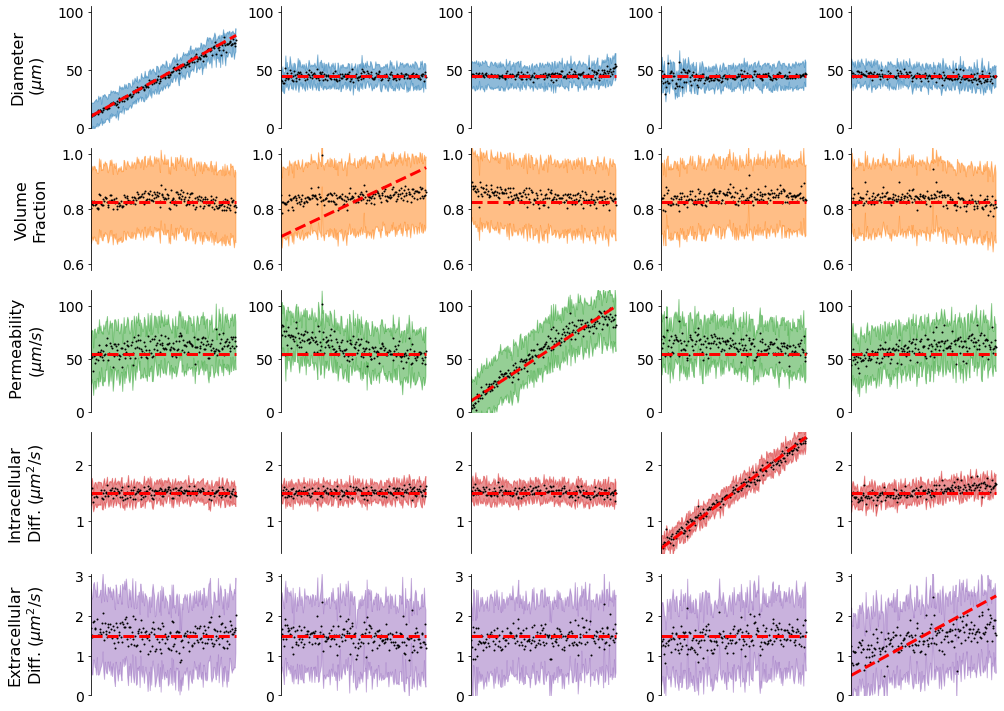

In [21]:
import seaborn as sns
# NOISE ONLY INPUTS
# ms_keys = ['Diameter ($\mu m$)', 'Volume \nFraction', 'Permeability \n($\mu m/s$)', 'Intracellular \nDiffusion ($\mu m^2/s$)', 'Extracellular \nDiffusion ($\mu m^2/s$)']
ms_keys = ['Diameter\n($\mu m$)    ', 'Volume\nFraction', ' Permeability\n($\mu m/s$)', 'Intracellular\nDiff. ($\mu m^2/s$)', 'Extracellular\nDiff. ($\mu m^2/s$)']
scaling = [1,0.01,1,0.1,0.1]
std_scaling = [1e6,1e2,1e6,1e10,1e10]


param_range = [[0,100],
              [0.6,1],
              [0,100],
              [0.5,2.5],
              [0,3.0]]
param_range = [[0,105],
              [0.58,1.02],
              [0,115],
              [0.41,2.59],
              [0,3.05]]


fig,axes = plt.subplots(5,5,figsize=(14,10))
for j in range(5):
    std_transform = (problem_train['bounds'][j][1]-problem_train['bounds'][j][0])/2 * 1/std_scaling[j]
    output_scaler.fit(outputs_inverse[:,j].reshape(-1, 1))
    temp_results = output_scaler.inverse_transform(test_results_single[j].reshape(-1, 1))
    
    temp_upper = output_scaler.inverse_transform((test_results_single[j] + test_std_single[j]**0.5*1.96).reshape(-1, 1))
    temp_lower = output_scaler.inverse_transform((test_results_single[j] - test_std_single[j]**0.5*1.96).reshape(-1, 1))
    
    print(temp_lower.flatten())
    print(temp_upper.flatten())
    
    temp_std = output_scaler.inverse_transform(test_std_single[j].reshape(-1, 1))
    temp_std = temp_std - np.mean(problem_train['bounds'][j])*std_scaling[j]
    for pl in range(5,10):
        R = j
        C = pl-5
        ax = axes[R,C]
        low = 200*pl
        high = 200*(pl+1)
                
        color = sns.color_palette(n_colors=5)
        ax.fill_between(np.linspace(0,199-1,200),y1 = (temp_lower[low:high]).flatten()*scaling[j], y2= (temp_upper[low:high]).flatten()*scaling[j], color =color[j], alpha = 0.5, )
        ax.plot(temp_results[low:high]*scaling[j], markersize=2, c='k',marker='.', linestyle='')
        ax.plot(outputs_inverse_test[:,j][low:high]*scaling[j],'r--', linewidth = 3)

        ax.set_ylim([param_range[j][0],param_range[j][1]])
        ax.set_xlim([0,200])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.tick_params(axis='both', which='major', labelsize=14)


        if pl-5 == 0:
            ax.set_ylabel(ms_keys[j], size = 16)
        labelx = -0.3
        ax.yaxis.set_label_coords(labelx, 0.5)

import seaborn as sns
plt.tight_layout()
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.show()

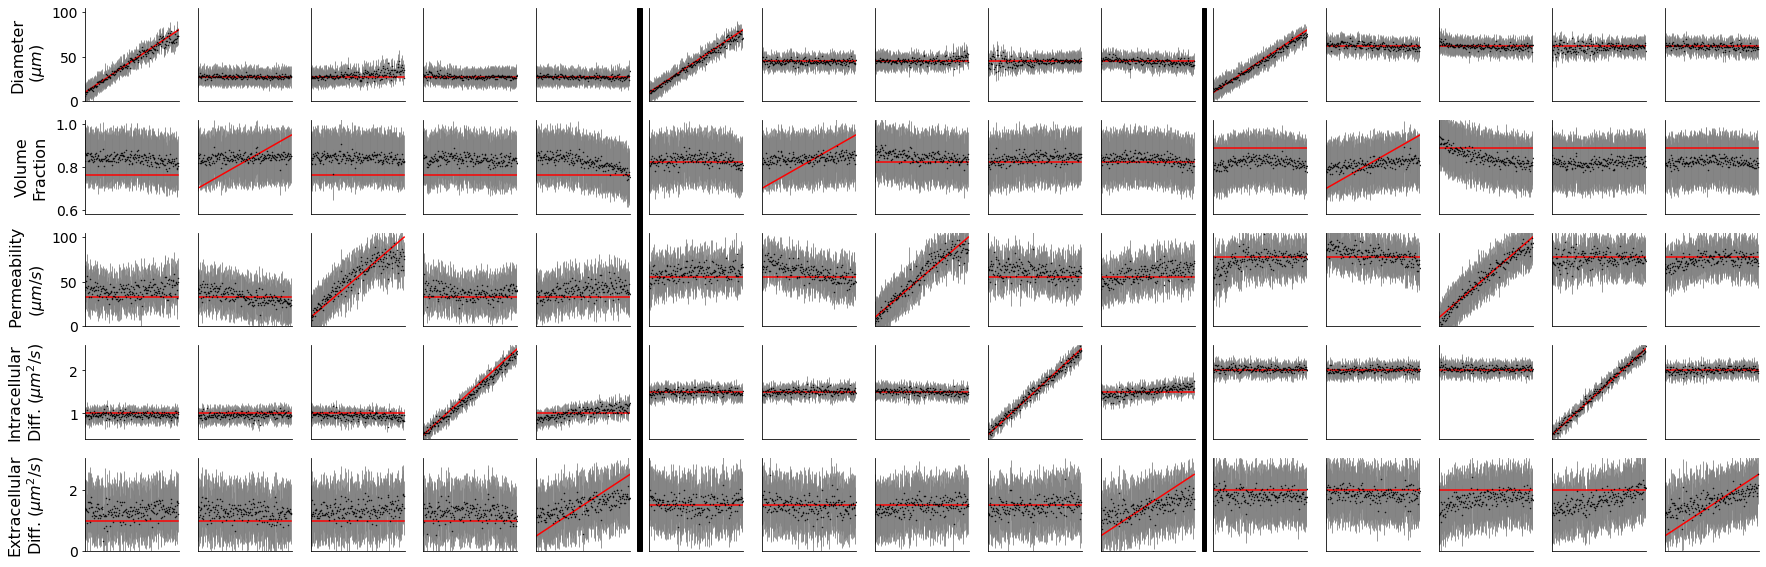

In [27]:
# NOISE ONLY INPUTS
# ms_keys = ['Diameter ($\mu m$)', 'Volume \nFraction', 'Permeability \n($\mu m/s$)', 'Intracellular \nDiffusion ($\mu m^2/s$)', 'Extracellular \nDiffusion ($\mu m^2/s$)']
ms_keys = ['Diameter\n($\mu m$)    ', 'Volume\nFraction', ' Permeability\n($\mu m/s$)     ', 'Intracellular\nDiff. ($\mu m^2/s$)', 'Extracellular\nDiff. ($\mu m^2/s$)']
scaling = [1,0.01,1,0.1,0.1]
std_scaling = [1e6,1e2,1e6,1e10,1e10]


param_range = [[0,100],
              [0.6,1],
              [0,100],
              [0.5,2.5],
              [0,3.0]]
param_range = [[0,105],
              [0.58,1.02],
              [0,105],
              [0.41,2.59],
              [0,3.05]]
# param_range = [[10,80],
#               [0.7,1],
#               [10,100],
#               [0.5,2.5],
#               [0.5,2.5]]

fig,axes = plt.subplots(5,15,figsize=(30,10))
for j in range(5):
    std_transform = (problem_train['bounds'][j][1]-problem_train['bounds'][j][0])/2 * 1/std_scaling[j]
#     print(param_range[j][1]-param_range[j][0])


    #     print(problem_train['bounds'][j][1]-problem_train['bounds'][j][0])
    output_scaler.fit(outputs_inverse[:,j].reshape(-1, 1))
    temp_results = output_scaler.inverse_transform(test_results_single[j].reshape(-1, 1))
    
    temp_upper = output_scaler.inverse_transform((test_results_single[j] + test_std_single[j]**0.5*1.96).reshape(-1, 1))
    temp_lower = output_scaler.inverse_transform((test_results_single[j] - test_std_single[j]**0.5*1.96).reshape(-1, 1))
    
    temp_std = output_scaler.inverse_transform(test_std_single[j].reshape(-1, 1))
    temp_std = temp_std - np.mean(problem_train['bounds'][j])*std_scaling[j]
#     temp_std = temp_upper - temp_results#test_std_single[j]*std_transform
    for pl in range(15):
        R = j
#         print(j)
        C = pl
        ax = axes[R,C]
        low = 200*pl
        high = 200*(pl+1)
        
#         print( ((temp_upper[low:high]-temp_results[low:high])*scaling[j]).flatten().shape )
        
        ax.errorbar(np.linspace(0,199-1,200),temp_results[low:high]*scaling[j], yerr= ((temp_upper[low:high]-temp_results[low:high])*scaling[j]).flatten(), ecolor ='grey',marker = '',linestyle = '', elinewidth=0.8)
        
#         ax.plot(temp_upper[low:high]*scaling[j],'-r')
#         ax.plot(temp_lower[low:high]*scaling[j],'-g')

        ax.plot(outputs_inverse_test[:,j][low:high]*scaling[j],'r-')
        ax.plot(temp_results[low:high]*scaling[j],markersize=1,c='k',marker='.',linestyle='')

        ax.set_ylim([param_range[j][0],param_range[j][1]])
        ax.set_xlim([0,200])
        
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         ax.spines['bottom'].set_visible(False)
#         ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.tick_params(axis='both', which='major', labelsize=14)

        if pl == 0:
            ax.set_ylabel(ms_keys[j], size = 16)
        else:
            ax.get_yaxis().set_ticks([])
        labelx = -0.4
        ax.yaxis.set_label_coords(labelx, 0.5)
plt.axvspan(-2185, -2175, 0, 5.8, clip_on=False,color='k')
plt.axvspan(-985, -975, 0, 5.8, clip_on=False,color='k')

# import seaborn as sns
# sns.despine()
plt.show()
# plt.tight_layout()
# plt.savefig('../GP_full_DNR30.pdf', format='pdf', bbox_inches='tight')

percentage of time true test value was 
within the 95% confidence interval of the GP


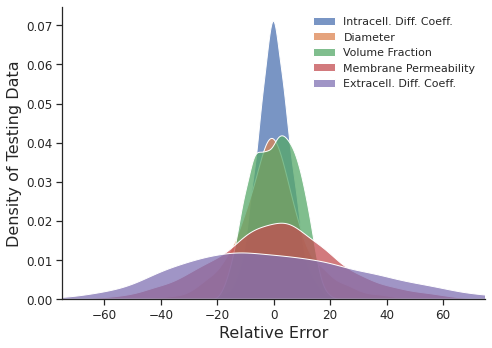

In [29]:
print('percentage of time true test value was \nwithin the 95% confidence interval of the GP')
import seaborn as sns

c = list(sns.color_palette(n_colors=5)[::-1])
sns.color_palette()[i]

names_clean = ['Diameter',
              'Volume Fraction',
              'Membrane Permeability',
              'Intracell. Diff. Coeff.',
              'Extracell. Diff. Coeff.']

err_plot = err_LBM_test_2

fig, ax = plt.subplots(figsize=(7,5))
sns.set(style="ticks")
for i in [3,0,1,2,4]:
    sns.kdeplot(err_plot[i], shade=True,  levels=50, gridsize=1000, multiple="stack", label=names_clean[i], )

    # xlabels = ['%2.2f' % (np.round(b,2)) for b in bins[1:]]
    # xlabels[-1] += '+'
    # for j in range(0,5):     
    #     xlabels[j] += '%'
    # N_labels = len(xlabels)
#     ax.set_xlim([-3, 3])
    ax.set_xlim([-75, 75])
#     ax.set_xticks([-75, -50,-25,0,25,50,75])
    # ax.set_ylim([0, 1])
    # ax.set_xticks((0.2 * np.arange(N_labels) + 0.1)*maxval)
    # ax.set_xticklabels(xlabels)
    ax.legend(loc='upper right', fontsize = 11,frameon=False)
    ax.set_xlabel('Relative Error', size = 16)
    ax.set_ylabel('Density of Testing Data', size = 16)
    # ax = plt.gca()
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    # plt.show()
    # plt.savefig('../GP_full_DNR30_accuracy.pdf', format='pdf', bbox_inches='tight')
# plt.legend()
sns.despine()
plt.tight_layout()
# plt.show()

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.savefig('full_hist_results_combined_DNR30.pdf', format='pdf', bbox_inches='tight')